In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
data = """
  method     ntot        4             64           256           1024
boyett      10     87.4±0.1μs   96.7±0.08μs    180±0.8μs     472±0.7μs
boyett     100      919±2μs       864±2μs       962±3μs       1.26±0ms
boyett     1000   9.04±0.01ms   8.12±0.01ms   7.99±0.03ms   8.15±0.03ms
boyett    10000    99.0±0.4ms    89.9±0.2ms    86.9±0.3ms    86.4±0.6ms
 boyett2      10     17.0±0.1ms      failed        failed        failed
 boyett2     100     22.9±0.2ms   23.6±0.05ms    24.4±0.2ms      failed
 boyett2     1000   85.4±0.09ms    93.0±0.4ms    97.6±0.5ms    102±0.8ms
 boyett2    10000     722±1ms       798±2ms       846±4ms       904±4ms
patefield     10     70.6±0.2μs     852±10μs      2.22±0ms      5.44±0ms
patefield    100    98.8±0.08μs   3.65±0.03ms    13.1±0.2ms    41.9±0.4ms
patefield    1000    122±0.2μs    4.53±0.01ms   19.5±0.01ms    71.9±0.3ms
patefield   10000    156±0.2μs      5.39±0ms    22.6±0.02ms    90.7±0.3ms
patefield2     10      112±2μs       1.17±0ms      2.94±0ms    6.48±0.02ms
patefield2    100      157±2μs     6.26±0.01ms   22.0±0.02ms    71.9±0.4ms
patefield2    1000    166±0.9μs    7.13±0.05ms    32.1±0.1ms     118±1ms
patefield2   10000    201±0.8μs    7.53±0.02ms    32.6±0.2ms    137±0.1ms
"""

In [8]:
d = {}
ncell = None
ntot = []
for line in data.split("\n"):
    if not line or line.isspace():
        continue
    method, ntoti, *times = [x for x in line.split() if x]
    if ncell is None:
        ncell = [int(x) for x in times]
        continue
    else:
        ntoti = int(ntoti)
        if ntoti not in ntot:
            ntot.append(ntoti)
    times = [(float(x.split("±")[0]) * (1e-3 if x.endswith("μs") else 1)) if x != "failed" else np.nan for x in times]
    d.setdefault(method, {})[ntoti] = times

times = {
    key: np.empty((len(ntot), len(ncell))) for key in d
}

ntot = np.sort(ntot)
ncell = np.array(ncell)

for key in d:
    v = times[key]
    for i, ntoti in enumerate(ntot):
        v[i] = d[key][ntoti]

Text(0.5, 0, 'total number of cells')

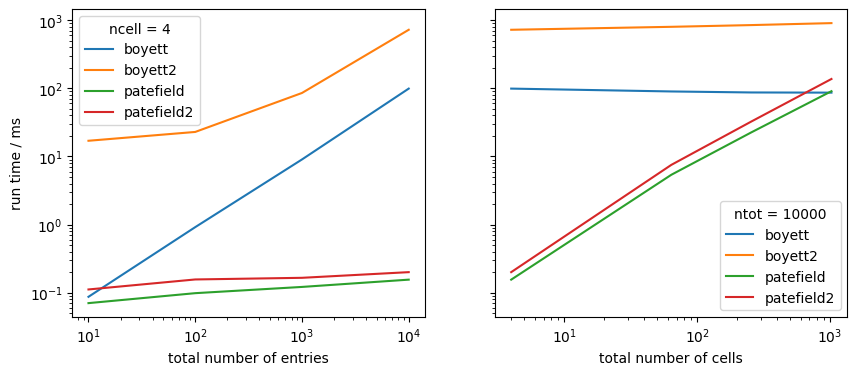

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

plt.sca(ax[0])
for key, val in times.items():
    plt.plot(ntot, val[:, 0], label=key)
plt.loglog()
plt.legend(title="ncell = 4")
plt.ylabel("run time / ms")
plt.xlabel("total number of entries")

plt.sca(ax[1])
for key, val in times.items():
    plt.plot(ncell, val[-1], label=key)
plt.loglog()
plt.legend(title="ntot = 10000")
plt.xlabel("total number of cells")

 active_mask: array([0, 0])
        cost: 1.3946620974325732
         fun: array([-4.03239230e-01, -1.21206891e-01,  3.07411523e-01,  7.97434019e-01,
        2.43799745e-01, -5.92996375e-01, -4.84587076e-01, -2.60966312e-01,
        6.07956704e-01, -2.33910748e-01, -3.07308913e-01, -2.25876351e-01,
        7.70147778e-01,  2.91843448e-04, -4.68183168e-02, -5.01314065e-02])
        grad: array([-1.91174556e-06, -5.01863655e-08])
         jac: array([[276.76918167,   0.83403245],
       [276.76918168,   0.83403245],
       [276.76918167,   0.83403244],
       [276.76918168,   0.83403245],
       [276.76918167,   1.52717962],
       [276.76918168,   1.52717963],
       [276.76918167,   1.52717962],
       [276.76918168,   1.52717963],
       [276.76918166,   1.93264473],
       [276.76918167,   1.93264474],
       [276.76918168,   1.93264474],
       [276.76918167,   1.93264474],
       [276.76918167,   2.2203268 ],
       [276.76918168,   2.2203268 ],
       [276.76918167,   2.2203268 ],

Text(0.5, 0, 'total number of cells')

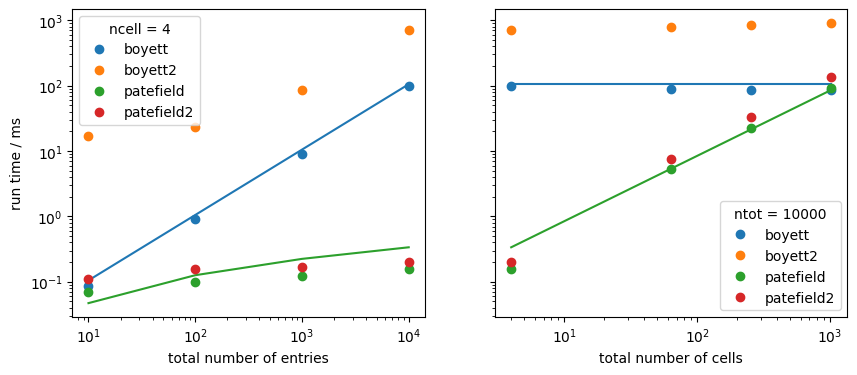

In [10]:
from scipy.optimize import least_squares

def patefield(ntot, ncell, par):
    return par[0] * np.outer(np.log(ntot) ** par[1], ncell)

def boyett(ntot, ncell, par):
    return par * np.outer(ntot, np.ones_like(ncell))

model = {}
r1 = least_squares(lambda par: np.log(patefield(ntot, ncell, par) / times["patefield"]).ravel(), (1.0, 1.0), bounds=np.transpose([(0, np.inf), (-2, 2)]))
assert r1.success
print(r1)
model["patefield"] = lambda ntot, ncell: patefield(ntot, ncell, r1.x)

r2 = least_squares(lambda par: np.log(boyett(ntot, ncell, par) / times["boyett"]).ravel(), 2.0, bounds=(0, np.inf))
assert r2.success
model["boyett"] = lambda ntot, ncell: boyett(ntot, ncell, r2.x[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

plt.sca(ax[0])
icell = 0
for key, val in times.items():
    l, = plt.plot(ntot, val[:, icell], "o", label=key)
    if key in model:
        m = model[key]
        plt.plot(ntot, m(ntot, ncell)[:, icell], "-", color=l.get_color())
plt.loglog()
plt.legend(title=f"ncell = {ncell[icell]}")
plt.ylabel("run time / ms")
plt.xlabel("total number of entries")

plt.sca(ax[1])
intot = -1
for key, val in times.items():
    l, = plt.plot(ncell, val[intot], "o", label=key)
    if key in model:
        m = model[key]
        plt.plot(ncell, m(ntot, ncell)[intot], "-", color=l.get_color())
plt.loglog()
plt.legend(title=f"ntot = {ntot[intot]}")
plt.xlabel("total number of cells")

In [11]:
for ntoti in ntot:
    for ncelli in ncell:
        print(ntoti, ncelli, model["boyett"](ntoti, ncelli) / ntoti  / (model["patefield"](ntoti, ncelli) / (np.log(ntoti) * ncelli)))

10 4 [[2.05157943]]
10 64 [[2.05157943]]
10 256 [[2.05157943]]
10 1024 [[2.05157943]]
100 4 [[1.53518469]]
100 64 [[1.53518469]]
100 256 [[1.53518469]]
100 1024 [[1.53518469]]
1000 4 [[1.29567967]]
1000 64 [[1.29567967]]
1000 256 [[1.29567967]]
1000 1024 [[1.29567967]]
10000 4 [[1.14876958]]
10000 64 [[1.14876958]]
10000 256 [[1.14876958]]
10000 1024 [[1.14876958]]
